# Mapping the Extent of mCDR Signals within Finite Regional Domains

This notebook demonstrates how to map the extent of marine Carbon Dioxide Removal (mCDR) signals within finite regional domains. The analysis involves:

1. **Defining the regional model grid**: Creating a finite regional ocean model grid using ROMS tools
2. **Loading the global atlas grid**: Using the POP ocean model grid as the base for the atlas dataset
3. **Identifying overlapping polygons**: Finding which atlas polygons intersect with the regional domain
4. **Integrating CO2 fluxes**: Computing cumulative CO2 uptake within the regional domain boundaries
5. **Visualizing results**: Mapping the fraction of CO2 uptake captured within the regional domain

The key challenge is determining what fraction of the global mCDR signal (from the atlas) is captured within a finite regional model domain, which is essential for understanding the efficiency and spatial extent of regional mCDR deployments.

## Step 1: Import Required Libraries

Load the necessary Python packages for data manipulation, grid handling, and analysis utilities.

In [ ]:
%load_ext autoreload
%autoreload 2

import numpy as np
import xarray as xr

import roms_tools as rt

import cdr_atlas
import parsers
import utils

/Users/mclong/miniconda3/envs/atlas-calcs/lib/python3.13/site-packages/pop_tools/__init__.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


In [ ]:
grid_yaml = "tests/_grid.yml"
test = True
dask_cluster_kwargs = {
    "account": "m4632",
    "queue_name": "premium",
    "scheduler_file": None,
}

## Step 2: Define the Regional Model Grid

Create a finite regional ocean model grid using ROMS (Regional Ocean Modeling System) tools. This grid defines the spatial boundaries of our regional domain. The grid parameters include:

- **Grid dimensions**: number of grid points
- **Physical size**: domain extent
- **Center location**: geographic center
- **Rotation**: grid rotation angle
- **Vertical levels**: number of vertical sigma levels

The grid is plotted to visualize the regional domain extent.

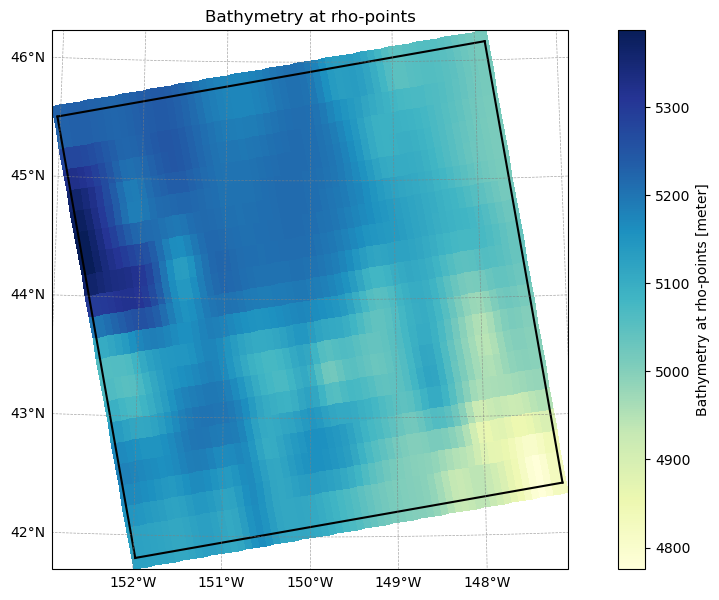

In [ ]:
model_grid = parsers.load_roms_tools_object(grid_yaml)
model_grid.plot()

## Step 2: Load the Global Atlas Grid

Load the POP (Parallel Ocean Program) global ocean model grid (`POP_gx1v7`), which serves as the base grid for the atlas dataset. This grid provides the spatial coordinates (TLAT, TLONG) and cell areas (TAREA) needed for area-weighted calculations.

In [4]:
atlas_grid = cdr_atlas.get_pop_grid()
atlas_grid

<xarray.Dataset> Size: 11MB
Dimensions:      (nlat: 384, nlon: 320, z_t: 60, z_w: 60, z_w_bot: 60, nreg: 13)
Coordinates:
  * z_t          (z_t) float64 480B 500.0 1.5e+03 ... 5.125e+05 5.375e+05
  * z_w          (z_w) float64 480B 0.0 1e+03 2e+03 ... 4.75e+05 5e+05 5.25e+05
  * z_w_bot      (z_w_bot) float64 480B 1e+03 2e+03 3e+03 ... 5.25e+05 5.5e+05
  * nreg         (nreg) int64 104B 0 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: nlat, nlon
Data variables: (12/15)
    TLAT         (nlat, nlon) float64 983kB -79.22 -79.22 -79.22 ... 72.19 72.19
    TLONG        (nlat, nlon) float64 983kB 320.6 321.7 322.8 ... 319.4 319.8
    ULAT         (nlat, nlon) float64 983kB -78.95 -78.95 -78.95 ... 72.41 72.41
    ULONG        (nlat, nlon) float64 983kB 321.1 322.3 323.4 ... 319.6 320.0
    DXT          (nlat, nlon) float64 983kB 1.894e+06 1.893e+06 ... 1.473e+06
    DYT          (nlat, nlon) float64 983kB 5.94e+06 5.94e+06 ... 5.046e+06
    ...           ...
    UAREA        (nlat, nlon) float64 983kB 1.423e+13 1.423e+13 ... 7.639e+12
    KMT          (nlat, nlon) int32 492kB 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
    REGION_MASK  (nlat, nlon) int32 492kB 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
    dz           (z_t) float64 480B 1e+03 1e+03 1e+03 ... 2.5e+04 2.5e+04
    region_name  (nreg) <U21 1kB 'Black Sea' 'Baltic Sea' ... 'Hudson Bay'
    region_val   (nreg) int64 104B -13 -12 -5 1 2 3 4 6 7 8 9 10 11
Attributes:
    lateral_dims:       [384, 320]
    vertical_dims:      60
    vert_grid_file:     gx1v7_vert_grid
    horiz_grid_fname:   inputdata/ocn/pop/gx1v7/grid/horiz_grid_20010402.ieeer8
    topography_fname:   inputdata/ocn/pop/gx1v7/grid/topography_20161215.ieeei4
    region_mask_fname:  inputdata/ocn/pop/gx1v7/grid/region_mask_20151008.ieeei4
    type:               dipole
    title:              POP_gx1v7 grid

## Step 4: Load Polygon Masks

Load the polygon masks from the atlas dataset. Each polygon represents a distinct mCDR injection location. The polygon IDs are masked to only include ocean points (where `KMT > 0`, indicating valid ocean grid cells).

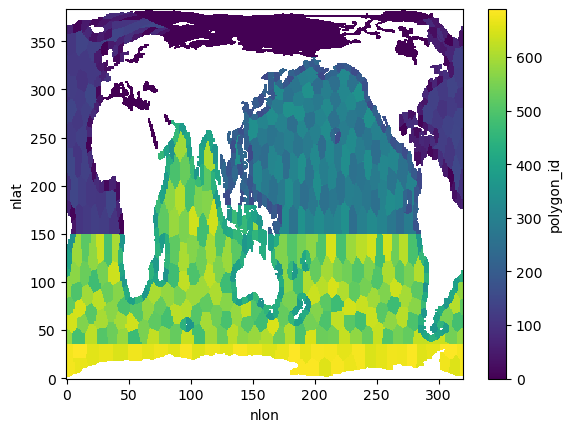

In [5]:
ds_atlas_polygons = cdr_atlas.get_polygon_masks_dataset()
polygon_ids = ds_atlas_polygons.polygon_id.where(atlas_grid.KMT > 0)
polygon_ids.plot()

## Step 5: Create Analyzer and Identify Overlapping Polygons

Initialize the `AtlasModelGridAnalyzer` class, which:

1. **Computes the convex hull** of the regional model grid using all lat/lon points from `model_grid.ds.lat_u` and `lon_u`
2. **Performs point-in-polygon tests** to identify which atlas grid points fall within the regional domain boundaries
3. **Extracts unique polygon IDs** that have at least some overlap with the regional domain
4. **Creates a polygon ID mask** where polygon IDs are set to -1 outside the regional domain

The analyzer uses a convex hull approach (rather than a simple bounding box) to accurately handle non-rectangular regional domains. The resulting mask shows which polygons intersect with the regional domain.p 

Found 3 unique polygon IDs within model grid boundaries
Polygon IDs: [250. 269. 320.]


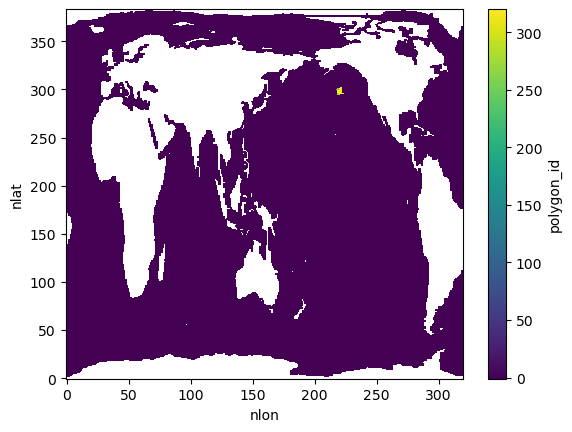

In [6]:
# Create AtlasModelGridAnalyzer instance
analyzer = cdr_atlas.AtlasModelGridAnalyzer(model_grid, atlas_grid, polygon_ids=polygon_ids)

# Get polygon IDs within model grid boundaries
print(f"Found {len(analyzer.polygon_ids_in_bounds)} unique polygon IDs within model grid boundaries")
print(f"Polygon IDs: {analyzer.polygon_ids_in_bounds[:100]}..." if len(analyzer.polygon_ids_in_bounds) > 100 else f"Polygon IDs: {analyzer.polygon_ids_in_bounds}")

analyzer.polygon_id_mask.plot(vmin=-1, vmax=analyzer.polygon_id_mask.max())

## Step 6: Test: Integrate CO<sub>2</sub> Flux for a Single Polygon

Compute the cumulative CO2 uptake for a single polygon over a 3-month period. The integration:

1. **Retrieves alk-forcing files** from S3 (with local caching) for the specified polygon, injection date, and time period
2. **Calculates the additional CO2 flux** (`FG_CO2_additional = FG_CO2 - FG_ALT_CO2`) which represents the mCDR signal
3. **Integrates over space and time** using:
   - Area weighting with `TAREA` (grid cell areas)
   - Time weighting with days per month converted to seconds
   - Spatial masking to restrict to points within the regional domain
4. **Computes cumulative integrals** over the elapsed time dimension

The results show:
- **Total integrated FG_CO2**: Total CO2 uptake over the entire polygon extent
- **Within model grid**: CO2 uptake within the regional domain boundaries
- **Fraction within grid**: Percentage of total uptake captured by the regional domain

In [7]:
years = [347+i for i in range(15)]
years

[347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361]

In [ ]:
cluster = utils.dask_cluster(**dask_cluster_kwargs)
cluster

2026-01-15 16:56:27 - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
/Users/mclong/miniconda3/envs/atlas-calcs/lib/python3.13/site-packages/distributed/node.py:188: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 49861 instead
  warnings.warn(
2026-01-15 16:56:27 - INFO - State start
2026-01-15 16:56:27 - INFO -   Scheduler at:     tcp://127.0.0.1:49862
2026-01-15 16:56:27 - INFO -   dashboard at:  http://127.0.0.1:49861/status
2026-01-15 16:56:27 - INFO - Registering Worker plugin shuffle
2026-01-15 16:56:27 - INFO -         Start Nanny at: 'tcp://127.0.0.1:49865'
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
2026-01-15 16:56:27 - INFO -         Start Nanny at: 'tcp://127.0.0.1:49867'
2026-01-15 16:56:27 - INFO -         Start Nanny at: 'tcp://127.0.0.1:49869'
Numba: 

Local cluster running at http://127.0.0.1:49861/status


2026-01-15 16:57:37 - INFO - Closing Nanny gracefully at 'tcp://127.0.0.1:49869'. Reason: worker-close
2026-01-15 16:57:37 - INFO - Closing Nanny gracefully at 'tcp://127.0.0.1:49867'. Reason: worker-close
2026-01-15 16:57:37 - INFO - Closing Nanny gracefully at 'tcp://127.0.0.1:49865'. Reason: worker-close
2026-01-15 16:57:37 - INFO - Closing Nanny gracefully at 'tcp://127.0.0.1:49871'. Reason: worker-close
2026-01-15 16:57:37 - INFO - Received 'close-stream' from tcp://127.0.0.1:49878; closing.
2026-01-15 16:57:37 - INFO - Received 'close-stream' from tcp://127.0.0.1:49881; closing.
2026-01-15 16:57:38 - INFO - Remove worker addr: tcp://127.0.0.1:49875 name: 1 (stimulus_id='handle-worker-cleanup-1768521458.001462')
2026-01-15 16:57:38 - INFO - Remove worker addr: tcp://127.0.0.1:49879 name: 2 (stimulus_id='handle-worker-cleanup-1768521458.003785')
2026-01-15 16:57:38 - INFO - Received 'close-stream' from tcp://127.0.0.1:49876; closing.
2026-01-15 16:57:38 - INFO - Received 'close-str

In [9]:
%%time
# Integrate FG_CO2 for polygon 000 over 3 months
# Using the alk-forcing files: 0347-01, 0347-02, 0347-03
results = analyzer.integrate_fg_co2_polygon(
    polygon_id=analyzer.polygon_ids_in_bounds[-1],
    years=years[-2:-1],
    months=[1, 2, 3],
)

print("FG_CO2 Integration Results:")
print(f"  Total integrated FG_CO2: {results['total'].values[-1]:.2e}")
print(f"  Within model grid: {results['within_grid'].values[-1]:.2e}")
print(f"  Fraction within grid: {results['fraction'].values[-1]:.2%}")

Using cached files for all 3 requested file(s).
FG_CO2 Integration Results:
  Total integrated FG_CO2: 1.48e+09
  Within model grid: 7.21e+05
  Fraction within grid: 0.05%
CPU times: user 835 ms, sys: 121 ms, total: 956 ms
Wall time: 3.1 s


## Step 7: Integrate CO<sub>2</sub> Flux for All Overlapping Polygons

Compute the cumulative CO2 uptake for all polygons that intersect with the regional domain. This provides a comprehensive view of how much of the global mCDR signal is captured within the finite regional domain. The results are concatenated along the `polygon_id` dimension, creating a dataset with dimensions `(polygon_id, elapsed_time)`.

In [ ]:
%%time
ds = None
if not test:
    ds = analyzer.integrate_fg_co2_all_polygons(
        years=years,
    )   
ds

Using cached files for all 180 requested file(s).
CPU times: user 10.9 s, sys: 3.09 s, total: 14 s
Wall time: 1min 6s


KeyboardInterrupt: 

## Step 8: Visualize Fraction of Uptake within Regional Domain

Map the fraction of CO2 uptake captured within the regional domain for each polygon. The visualization shows:

- **Red regions**: Polygons where a large fraction of CO2 uptake occurs within the regional domain
- **Blue regions**: Polygons where most CO2 uptake occurs outside the regional domain

This spatial map helps identify which mCDR injection locations are most effectively captured by the regional model domain, which is critical for understanding the efficiency of regional mCDR monitoring and modeling efforts.

In [ ]:
if ds is not None:
    analyzer.set_field_within_boundaries(ds.fraction.isel(elapsed_time=-1)).plot(cmap="RdBu_r")


In [ ]:
# check if LocalCluster is running and shutdown
if cluster.local_cluster:
    cluster.shutdown()

2026-01-15 16:55:52 - INFO - Closing Nanny at 'tcp://127.0.0.1:49726'. Reason: nanny-close
2026-01-15 16:55:52 - INFO - Nanny asking worker to close. Reason: nanny-close
2026-01-15 16:55:52 - INFO - Closing Nanny at 'tcp://127.0.0.1:49728'. Reason: nanny-close
2026-01-15 16:55:52 - INFO - Nanny asking worker to close. Reason: nanny-close
2026-01-15 16:55:52 - INFO - Closing Nanny at 'tcp://127.0.0.1:49730'. Reason: nanny-close
2026-01-15 16:55:52 - INFO - Nanny asking worker to close. Reason: nanny-close
2026-01-15 16:55:52 - INFO - Closing Nanny at 'tcp://127.0.0.1:49732'. Reason: nanny-close
2026-01-15 16:55:52 - INFO - Nanny asking worker to close. Reason: nanny-close
2026-01-15 16:55:53 - INFO - Nanny at 'tcp://127.0.0.1:49730' closed.
2026-01-15 16:55:53 - INFO - Nanny at 'tcp://127.0.0.1:49726' closed.
2026-01-15 16:55:53 - INFO - Nanny at 'tcp://127.0.0.1:49732' closed.
2026-01-15 16:55:53 - INFO - Nanny at 'tcp://127.0.0.1:49728' closed.
